In [2]:
%load_ext autoreload
%autoreload 2 
#default_exp model

In [3]:
#exporti
from fastai.tabular.all import * 
from tabnet.sparsemax import Sparsemax

In [ ]:
! pip install -e ../../libraries/fastai ../../libraries/fastcore 

# Creating the model 


In [4]:
class GBN(torch.nn.Module):
    """
        Ghost Batch Normalization
        https://arxiv.org/abs/1705.08741
    """

    def __init__(self, input_dim, virtual_batch_size=128, momentum=0.02):
        super(GBN, self).__init__()

        self.input_dim = input_dim
        self.virtual_batch_size = virtual_batch_size
        self.bn = BatchNorm(self.input_dim, momentum=momentum, ndim=1)

    def forward(self, x):
        chunks = x.chunk(int(np.ceil(x.shape[0] / self.virtual_batch_size)), 0)
        res = [self.bn(x_) for x_ in chunks]

        return torch.cat(res, dim=0)


In [47]:
class TabNet(Module):
    
    def __init__(self, emb_szs, n_cont, out_features, n_d, n_a, n_steps, n_shared_ft_blocks=2,
                         n_independent_ft_blocks=2, gamma=1.5, virtual_batch_size=128, momentum=0.2):        
        store_attr()
        
        self.embeds = nn.ModuleList([Embedding(ni, nf) for ni,nf in emb_szs])
        self.n_emb = sum(e.embedding_dim for e in self.embeds)
        self.n_features = self.n_emb + n_cont
        
        
#         intermediate_features = n_d + n_a 
#         self.shared_ft_blocks = [FeatureTransformerBlock(self.n_features, intermediate_features, virtual_batch_size, 
#                                                          is_first=True)] + \
#                                 [FeatureTransformerBlock(intermediate_features, intermediate_features, virtual_batch_size,
#                                                          is_first=False) for _ in range(n_shared_ft_blocks-1)]
        

        shared_feat_transform = None
        if self.n_shared_ft_blocks > 0: 
            lst = [nn.Linear(self.n_features, 2*(n_d + n_a), bias=False)] + \
                  [nn.Linear(n_d + n_a, 2*(n_d + n_a), bias=False) for _ in range(self.n_shared_ft_blocks-1)]
            shared_feat_transform = torch.nn.ModuleList(lst)
        

        self.initial_ft = FeatTransformer(self.n_features, n_d+n_a, shared_feat_transform,
                                                n_glu_independent=self.n_independent_ft_blocks,
                                                virtual_batch_size=self.virtual_batch_size,
                                                momentum=momentum)

    
        
        self.initial_bn = BatchNorm(self.n_features, ndim=1)
#         self.initial_ft = FeatureTransformer(self.shared_ft_blocks, n_d, n_a, n_independent_ft_blocks, virtual_batch_size)
        
        self.att_steps = nn.ModuleList([AttentiveTransformer(n_a, self.n_features,virtual_batch_size, momentum) 
                                            for i in range(self.n_steps)])
                
        self.ft_steps = nn.ModuleList([FeatTransformer(self.n_features, n_d+n_a, shared_feat_transform,
                                                          n_glu_independent=self.n_independent_ft_blocks,
                                                          virtual_batch_size=self.virtual_batch_size, momentum=momentum)
                                               for _ in range(n_steps)])

#         self.ft_steps = nn.ModuleList([FeatureTransformer(self.shared_ft_blocks, n_d, n_a,
#                                                           n_independent_ft_blocks, virtual_batch_size) 
#                                             for i in range(self.n_steps)])
        
        self.final_fc = nn.Linear(n_d, out_features)
    
    def forward(self, x_cat, x_cont):
        x = self._combine_cat_cont(x_cat, x_cont)
        
        output = 0
        x = self.initial_bn(x)
        res = self.initial_ft(x)
        d, a = res[:,:self.n_d], res[:,self.n_d:]
        
        prior = torch.ones(self.n_features, device=x_cont.device)
        
        for i in range(self.n_steps):
            M = self.att_steps[i](prior, a)
            prior = (self.gamma - M)*prior
            res = M * x
            res = self.ft_steps[i](res)
            d, a = res[:,:self.n_d], res[:,self.n_d:]
            output = output + nn.functional.relu(d)
        
        res = self.final_fc(output)
        return res
    
    def _combine_cat_cont(self, x_cat, x_cont):
        if self.n_emb != 0:
            x = [e(x_cat[:,i]) for i,e in enumerate(self.embeds)]
            x = torch.cat(x, 1)
        if self.n_cont != 0:
            x = torch.cat([x, x_cont], 1) if self.n_emb != 0 else x_cont
        
        return x

In [48]:
class AttentiveTransformer(Module):
    
    def __init__(self, n_a, in_features, virtual_batch_size, momentum):
        store_attr()
        self.fc = nn.Linear(n_a, in_features)
        self.bn = GBN(in_features, virtual_batch_size, momentum)
        self.sparsemax = Sparsemax()
        
    def forward(self, prior, a):
        a = self.fc(a)
        a = self.bn(a)
        a = prior * a
        M = self.sparsemax(a)
        return M

In [49]:
#exporti



    
class FeatTransformer(torch.nn.Module):
    def __init__(self, input_dim, output_dim, shared_layers, n_glu_independent,
                 virtual_batch_size=128, momentum=0.02):
        super(FeatTransformer, self).__init__()
        """
        Initialize a feature transformer.
        Parameters
        ----------
        - input_dim : int
            Input size
        - output_dim : int
            Outpu_size
        - n_glu_independant
        - shared_blocks : torch.nn.ModuleList
            The shared block that should be common to every step
        - momentum : float
            Float value between 0 and 1 which will be used for momentum in batch norm
        """

        params = {
            'n_glu': n_glu_independent,
            'virtual_batch_size': virtual_batch_size,
            'momentum': momentum
        }

        if shared_layers is None:
            # no shared layers
            self.shared = torch.nn.Identity()
            is_first = True
        else:
            self.shared = GLU_Block(input_dim, output_dim,
                                    first=True,
                                    shared_layers=shared_layers,
                                    n_glu=len(shared_layers),
                                    virtual_batch_size=virtual_batch_size,
                                    momentum=momentum)
            is_first = False

        if n_glu_independent == 0:
            # no independent layers
            self.specifics = torch.nn.Identity()
        else:
            spec_input_dim = input_dim if is_first else output_dim
            self.specifics = GLU_Block(spec_input_dim, output_dim,
                                       first=is_first,
                                       **params)

    def forward(self, x):
        x = self.shared(x)
        x = self.specifics(x)
        return x


class GLU_Block(torch.nn.Module):
    """
        Independant GLU block, specific to each step
    """

    def __init__(self, input_dim, output_dim, n_glu=2, first=False, shared_layers=None,
                 virtual_batch_size=128, momentum=0.02):
        super(GLU_Block, self).__init__()
        self.first = first
        self.shared_layers = shared_layers
        self.n_glu = n_glu
        self.glu_layers = torch.nn.ModuleList()

        params = {
            'virtual_batch_size': virtual_batch_size,
            'momentum': momentum
        }

        fc = shared_layers[0] if shared_layers else None
        self.glu_layers.append(GLU_Layer(input_dim, output_dim,
                                         fc=fc,
                                         **params))
        for glu_id in range(1, self.n_glu):
            fc = shared_layers[glu_id] if shared_layers else None
            self.glu_layers.append(GLU_Layer(output_dim, output_dim,
                                             fc=fc,
                                             **params))

    def forward(self, x):
        scale = torch.sqrt(torch.FloatTensor([0.5]).to(x.device))
        if self.first:  # the first layer of the block has no scale multiplication
            x = self.glu_layers[0](x)
            layers_left = range(1, self.n_glu)
        else:
            layers_left = range(self.n_glu)

        for glu_id in layers_left:
            x = torch.add(x, self.glu_layers[glu_id](x))
            x = x*scale
        return x


class GLU_Layer(torch.nn.Module):
    def __init__(self, input_dim, output_dim, fc=None,
                 virtual_batch_size=128, momentum=0.02):
        super(GLU_Layer, self).__init__()

        self.output_dim = output_dim
        if fc:
            self.fc = fc
        else:
            self.fc = nn.Linear(input_dim, 2*output_dim, bias=False)
#         initialize_glu(self.fc, input_dim, 2*output_dim)

        self.bn = GBN(2*output_dim, virtual_batch_size=virtual_batch_size,
                      momentum=momentum)

    def forward(self, x):
        x = self.fc(x)
        x = self.bn(x)
        out = torch.mul(x[:, :self.output_dim], torch.sigmoid(x[:, self.output_dim:]))
        return out

In [50]:
# class FeatureTransformer(Module):
    
#     def __init__(self, shared_blocks, n_d, n_a, n_independent_ft_blocks, virtual_batch_size):
#         store_attr()
#         intermediate_features = n_d + n_a
#         steps = [FeatureTransformerBlock(intermediate_features, intermediate_features, virtual_batch_size, False) 
#                              for _ in range(n_independent_ft_blocks)]
#         self.steps = nn.Sequential(*[*shared_blocks, *steps])
        
#     def forward(self, x):
#         res = self.steps(x)
#         d, a = res[:,:self.n_d], res[:,self.n_d:]
#         return d, a

In [51]:
# class FeatureTransformerBlock(Module):
#     def __init__(self, in_features, intermediate_features, virtual_batch_size, is_first, norm=math.sqrt(0.5)):
#         store_attr()
        
#         self.block1 = self._create_inner_block(is_first=True)
#         self.block2 = self._create_inner_block(is_first=False)
        
        
#     def forward(self, x):
#         x1 = self.block1(x)
#         if not self.is_first: x1 = (x1 + x)*self.norm
#         x2 = self.block2(x1)
#         x2 = (x2 + x1)*self.norm
#         return x2
        
        
#     def _create_inner_block(self, is_first):
#         intermediate_features = self.intermediate_features
#         in_features = self.in_features if is_first else intermediate_features
        
#         return nn.Sequential(*[
#             nn.Linear(in_features, 2*intermediate_features),
#             GBN(2*intermediate_features, self.virtual_batch_size),
#             nn.GLU(),
#         ])        
        
        
    

In [52]:
# N = 3
# n_features = 32
# n_d = n_a = 7 
# n_steps = 3
# out_features = 10
# virtual_batch_size = 5

# a = torch.randn((N, n_features))
# ft = FeatureTransformerBlock(n_features, n_d+n_a, virtual_batch_size, is_first=True)
# test_eq(ft(a).shape, (N, n_d+n_a))

In [53]:
a = torch.randn((N, n_features))
tabnet = TabNet([], n_features, out_features, n_d, n_a, n_steps, virtual_batch_size=virtual_batch_size)
test_eq(tabnet(a, a).shape, (N, out_features))

# Forest Cover DS

In [ ]:
data_dir = Path('./data')

In [ ]:
def extract_gzip(file, dest=None):
    import gzip
    dest = dest or Path(dest)
    with gzip.open(file, 'rb') as f_in:
        with open(dest / file.stem, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

In [ ]:
forest_type_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz'
forest_path = untar_data(forest_type_url, dest=data_dir, extract_func=extract_gzip)

In [ ]:
target = "Covertype"

cat_names = [
    "Wilderness_Area1", "Wilderness_Area2", "Wilderness_Area3",
    "Wilderness_Area4", "Soil_Type1", "Soil_Type2", "Soil_Type3", "Soil_Type4",
    "Soil_Type5", "Soil_Type6", "Soil_Type7", "Soil_Type8", "Soil_Type9",
    "Soil_Type10", "Soil_Type11", "Soil_Type12", "Soil_Type13", "Soil_Type14",
    "Soil_Type15", "Soil_Type16", "Soil_Type17", "Soil_Type18", "Soil_Type19",
    "Soil_Type20", "Soil_Type21", "Soil_Type22", "Soil_Type23", "Soil_Type24",
    "Soil_Type25", "Soil_Type26", "Soil_Type27", "Soil_Type28", "Soil_Type29",
    "Soil_Type30", "Soil_Type31", "Soil_Type32", "Soil_Type33", "Soil_Type34",
    "Soil_Type35", "Soil_Type36", "Soil_Type37", "Soil_Type38", "Soil_Type39",
    "Soil_Type40"
]

cont_names = [
    "Elevation", "Aspect", "Slope", "Horizontal_Distance_To_Hydrology",
    "Vertical_Distance_To_Hydrology", "Horizontal_Distance_To_Roadways",
    "Hillshade_9am", "Hillshade_Noon", "Hillshade_3pm",
    "Horizontal_Distance_To_Fire_Points"
]

feature_columns = (
    cont_names + cat_names + [target])

In [ ]:
df = pd.read_csv(forest_path, header=None, names=feature_columns); df.head()
df = df_shrink(df)

In [ ]:
procs = [Categorify, FillMissing, Normalize]
splits = RandomSplitter(0.05)(range_of(df))

In [ ]:
to = TabularPandas(df, procs, cat_names, cont_names, y_names=target, y_block = CategoryBlock(), splits=splits)
dls = to.dataloaders(bs=64*64*4)

In [ ]:
model = TabNet(get_emb_sz(to), len(to.cont_names), dls.c, n_d=64, n_a=64, n_steps=5, virtual_batch_size=256)
opt_func = partial(Adam, wd=0.01, eps=1e-5)
learn = Learner(dls, model, CrossEntropyLossFlat(), opt_func=opt_func, lr=3e-2, metrics=[accuracy])

In [ ]:
learn.fit_one_cycle(120)

# Poker Hand DS

In [6]:
BASE_DIR = Path.home().joinpath('data/tabnet/poker')

In [7]:
df = pd.read_csv(BASE_DIR.joinpath('train.csv'))
df.head()

,S1,C1,S2,C2,S3,C3,S4,C4,S5,C5,hand
0,4,9,2,1,2,2,4,7,2,8,0
1,1,4,3,6,1,12,3,11,2,7,0
2,1,11,4,1,3,7,4,11,2,1,2
3,2,9,2,4,3,6,1,9,4,9,3
4,1,8,2,4,2,11,2,2,2,1,0


In [ ]:
cat_names = ['S1', 'S2', 'S3', 'S4', 'S5', 'C1', 'C2', 'C3', 'C4', 'C5']
cont_names = []
target = ['hand']

In [ ]:
procs = [Categorify, Normalize]
splits = RandomSplitter(0.05)(range_of(df))

In [ ]:
to = TabularPandas(df, procs, cat_names, cont_names, y_names=target, y_block = CategoryBlock(), splits=splits)
dls = to.dataloaders(bs=64*4)

In [7]:
model = TabNet(get_emb_sz(to), len(to.cont_names), dls.c, n_d=16, n_a=16, 
                    n_steps=5, virtual_batch_size=256, gamma=1.5)

NameError: name 'TabNet' is not defined

In [ ]:
opt_func = partial(Adam, eps=1e-5)
learn = Learner(dls, model, CrossEntropyLossFlat(), opt_func=opt_func, lr=3e-2, metrics=[accuracy])

In [ ]:
learn.fit_one_cycle(1000)

# Adult 

In [54]:
adult_path = untar_data(URLs.ADULT_SAMPLE)
df = pd.read_csv(adult_path/'adult.csv')
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,49,Private,101320,Assoc-acdm,12.0,Married-civ-spouse,NaN,Wife,White,Female,0,1902,40,United-States,>=50k
1,44,Private,236746,Masters,14.0,Divorced,Exec-managerial,Not-in-family,White,Male,10520,0,45,United-States,>=50k
2,38,Private,96185,HS-grad,NaN,Divorced,NaN,Unmarried,Black,Female,0,0,32,United-States,<50k
3,38,Self-emp-inc,112847,Prof-school,15.0,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,40,United-States,>=50k
4,42,Self-emp-not-inc,82297,7th-8th,NaN,Married-civ-spouse,Other-service,Wife,Black,Female,0,0,50,United-States,<50k


In [55]:
splits = RandomSplitter(valid_pct=0.2)(range_of(df))
to = TabularPandas(df, procs=[Categorify, FillMissing,Normalize],
                   cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race'],
                   cont_names = ['age', 'fnlwgt', 'education-num'],
                   y_names='salary',
                   splits=splits)


In [56]:
dls = to.dataloaders(bs=1024)


In [57]:
model = TabNet(get_emb_sz(to), len(to.cont_names), dls.c, n_d=16, n_a=16, 
                    n_steps=5, virtual_batch_size=256, gamma=1.5)

In [58]:
opt_func = partial(Adam, eps=1e-5)
learn = Learner(dls, model, CrossEntropyLossFlat(), opt_func=opt_func, lr=3e-2, metrics=[accuracy])

SuggestedLRs(lr_min=0.15848932266235352, lr_steep=0.3630780577659607)

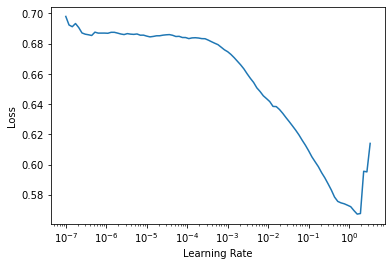

In [59]:
learn.lr_find()

In [60]:
learn.fit_one_cycle(150, 1e-1/2)

epoch,train_loss,valid_loss,accuracy,time
0,0.563679,0.567125,0.761978,00:01
1,0.514371,0.516975,0.779330,00:01
2,0.482633,0.433185,0.791308,00:01
3,0.458221,0.424750,0.801751,00:01
4,0.439874,0.412007,0.802211,00:01
5,0.429047,0.417405,0.800983,00:01
6,0.418799,0.426190,0.786855,00:01
7,0.413431,0.414170,0.808507,00:01
8,0.409281,0.423823,0.795762,00:01
9,0.406037,0.403161,0.804822,00:01


KeyboardInterrupt: 

# Export

In [ ]:
from nbdev.export import notebook2script
notebook2script()